# Nature Classifier

In [1]:
# Import pacakges used throughout
import os
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from cnn_model import BasicMultiClassCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda


In [2]:
# Establish constants
HEIGHT = 150
WIDTH = 150
IN_CHANNELS = 3
CLASSES = 6

num_train_buildings = 2191
num_test_buildings = 437


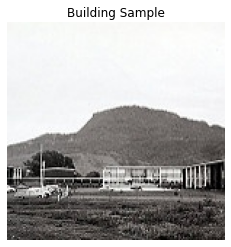

In [3]:
# View Building Sample
plt.title("Building Sample")
plt.axis("off")
plt.imshow(Image.open("data/train/buildings/0.jpg"))

num_train_buildings = sum(os.path.isfile(os.path.join("data/train/buildings/", f)) for f in os.listdir("data/train/buildings/"))
num_test_buildings = sum(os.path.isfile(os.path.join("data/test/buildings/", f)) for f in os.listdir("data/test/buildings/"))

print(f"{num_train_buildings = }")
print(f"{num_test_buildings = }")

num_train_forest = 2271
num_test_forest = 474


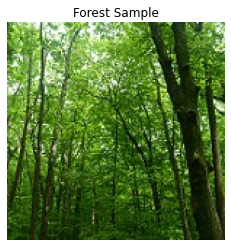

In [4]:
# View Forest Sample
plt.title("Forest Sample")
plt.axis("off")
plt.imshow(Image.open("data/train/forest/8.jpg"))

num_train_forest = sum(os.path.isfile(os.path.join("data/train/forest/", f)) for f in os.listdir("data/train/forest/"))
num_test_forest = sum(os.path.isfile(os.path.join("data/test/forest/", f)) for f in os.listdir("data/test/forest/"))

print(f"{num_train_forest = }")
print(f"{num_test_forest = }")

num_train_glacier = 2404
num_test_glacier = 553


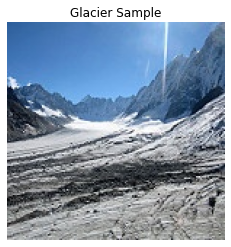

In [5]:
# View Glacier Sample
plt.title("Glacier Sample")
plt.axis("off")
plt.imshow(Image.open("data/train/glacier/10.jpg"))

num_train_glacier = sum(os.path.isfile(os.path.join("data/train/glacier/", f)) for f in os.listdir("data/train/glacier/"))
num_test_glacier = sum(os.path.isfile(os.path.join("data/test/glacier/", f)) for f in os.listdir("data/test/glacier/"))

print(f"{num_train_glacier = }")
print(f"{num_test_glacier = }")

num_train_mountain = 2512
num_test_mountain = 525


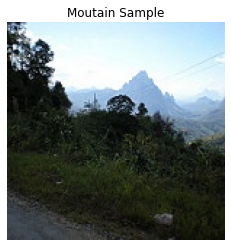

In [6]:
# View Moutain Sample
plt.title("Moutain Sample")
plt.axis("off")
plt.imshow(Image.open("data/train/mountain/16.jpg"))

num_train_mountain = sum(os.path.isfile(os.path.join("data/train/mountain/", f)) for f in os.listdir("data/train/mountain/"))
num_test_mountain = sum(os.path.isfile(os.path.join("data/test/mountain/", f)) for f in os.listdir("data/test/mountain/"))

print(f"{num_train_mountain = }")
print(f"{num_test_mountain = }")

num_train_sea = 2274
num_test_sea = 510


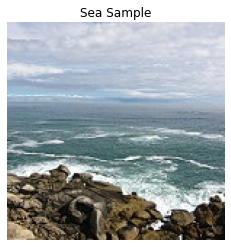

In [7]:
# View Sea Sample
plt.title("Sea Sample")
plt.axis("off")
plt.imshow(Image.open("data/train/sea/7.jpg"))

num_train_sea = sum(os.path.isfile(os.path.join("data/train/sea/", f)) for f in os.listdir("data/train/sea/"))
num_test_sea = sum(os.path.isfile(os.path.join("data/test/sea/", f)) for f in os.listdir("data/test/sea/"))

print(f"{num_train_sea = }")
print(f"{num_test_sea = }")

num_train_street = 2382
num_test_street = 501


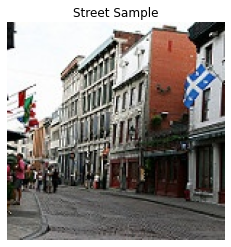

In [8]:
# View Street Sample
plt.title("Street Sample")
plt.axis("off")
plt.imshow(Image.open("data/train/street/9.jpg"))

num_train_street = sum(os.path.isfile(os.path.join("data/train/street/", f)) for f in os.listdir("data/train/street/"))
num_test_street = sum(os.path.isfile(os.path.join("data/test/street/", f)) for f in os.listdir("data/test/street/"))

print(f"{num_train_street = }")
print(f"{num_test_street = }")

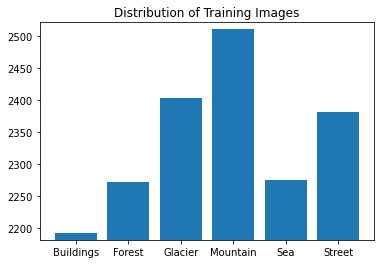

Num train samples: 14034


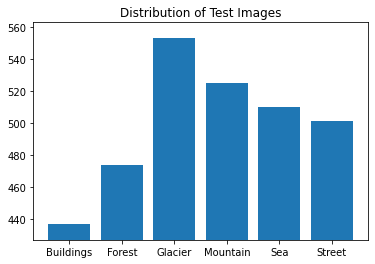

Num test samples: 3000


In [9]:
# Distribution of training/test images
classes = ["Buildings", "Forest", "Glacier", "Mountain", "Sea", "Street"]
num_train_classes = [num_train_buildings, num_train_forest, num_train_glacier,
               num_train_mountain, num_train_sea, num_train_street]

plt.title("Distribution of Training Images")
plt.bar(classes, num_train_classes)
plt.ylim(bottom=min(num_train_classes) - 10, top = max(num_train_classes) + 10)
plt.show()

num_train_samples = sum(num_train_classes)
print(f"Num train samples: {num_train_samples}")

# Distribution of training/test images
num_test_classes = [num_test_buildings, num_test_forest, num_test_glacier,
               num_test_mountain, num_test_sea, num_test_street]

plt.title("Distribution of Test Images")
plt.bar(classes, num_test_classes)
plt.ylim(bottom=min(num_test_classes) - 10, top = max(num_test_classes) + 10)
plt.show()

num_test_samples = sum(num_test_classes)
print(f"Num test samples: {num_test_samples}")

In [10]:
# Import data
transform_images = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(
    "data/train", transform=transform_images)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)

test_dataset = datasets.ImageFolder(
    "data/test", transform=transform_images)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [16]:
# Train and Test Functions
def train_function(model, train_dataloader, optimizer, criterion, learning_rate, epoch, device):
    model.train()
    total_loss = 0.
    start_time = time.time()
    log_interval = len(train_dataloader)//5

    for batch_num, (images, class_num) in enumerate(train_dataloader):
        images = images.to(device)
        class_num = class_num.to(device)

        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, class_num)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        if batch_num % log_interval == 0 and batch_num > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:03.3f} | ms/batch {:5.2f} | '
                  'loss {:5.5f}'.format(
                      epoch, batch_num, len(
                          train_dataloader.dataset) // train_dataloader.batch_size,
                      learning_rate, elapsed * 1000 / log_interval,
                      cur_loss))
            total_loss = 0
            start_time = time.time()


def evaluate(eval_model, test_dataloader, num_test_samples, criterion):
    eval_model.eval()
    num_correct = 0

    with torch.no_grad():
        for (images, class_num) in test_dataloader:
            images = images.to(device)
            class_num = class_num.to(device)

            output = eval_model(images)
            loss = criterion(output, class_num)
            num_correct += torch.sum(torch.eq(torch.argmax(output,
                                     dim=1), class_num)).item()

    return num_correct / num_test_samples, loss.item()


In [17]:
# Train model
epochs = 10
learning_rate = 0.001

conv_net = BasicMultiClassCNN(
    in_channels=IN_CHANNELS, height=HEIGHT, width=WIDTH, classes=CLASSES).to(device)
criterion = nn.NLLLoss()
optimizer = Adam(conv_net.parameters(), learning_rate)

best_accuracy = 0.
best_model = None
accuracy_list = []
valid_loss_list = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_function(conv_net, train_dataloader, optimizer,
                   criterion, learning_rate, epoch, device)
    accuracy, loss = evaluate(conv_net, test_dataloader, num_test_samples, criterion)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | validation accuracy {:2.3f}% | '.format(
        epoch, (time.time() - epoch_start_time), accuracy*100))
    print('-' * 89)

    accuracy_list.append(accuracy)
    valid_loss_list.append(loss)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = conv_net


| epoch   1 |    87/  438 batches | lr 0.001 | ms/batch 99.09 | loss 1.55705
| epoch   1 |   174/  438 batches | lr 0.001 | ms/batch 100.53 | loss 1.13315
| epoch   1 |   261/  438 batches | lr 0.001 | ms/batch 97.19 | loss 1.07421
| epoch   1 |   348/  438 batches | lr 0.001 | ms/batch 98.32 | loss 1.06669
| epoch   1 |   435/  438 batches | lr 0.001 | ms/batch 99.19 | loss 1.01915
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 48.04s | validation accuracy 64.333% | 
-----------------------------------------------------------------------------------------
| epoch   2 |    87/  438 batches | lr 0.001 | ms/batch 97.76 | loss 0.96128
| epoch   2 |   174/  438 batches | lr 0.001 | ms/batch 92.79 | loss 0.91068
| epoch   2 |   261/  438 batches | lr 0.001 | ms/batch 90.93 | loss 0.82196
| epoch   2 |   348/  438 batches | lr 0.001 | ms/batch 94.42 | loss 0.79848
| epoch   2 |   435/  438 batches | lr 0.001 | ms/batch 93.

best_accuracy = 0.801


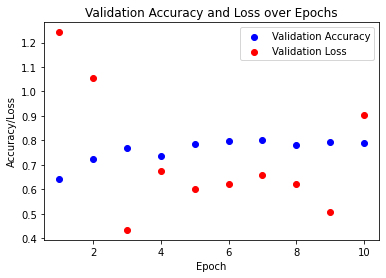

In [21]:
# Graph of validation loss and accuracy
x_vals = list(range(1, 11))
plt.scatter(x_vals, accuracy_list, label = "Validation Accuracy", color = "blue")
plt.scatter(x_vals, valid_loss_list, label = "Validation Loss", color = "red")
plt.title("Validation Accuracy and Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend()

print(f"{best_accuracy = }")

Predicted Class: Buildings
Correct! :)


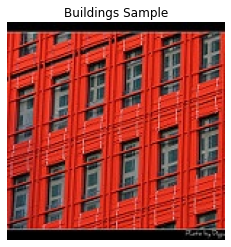

In [32]:
# Test model on random image
random_sample = random.choice(test_dataset.imgs)
image = Image.open(random_sample[0])
class_num = random_sample[1]

plt.title(f"{classes[class_num]} Sample")
plt.axis("off")
plt.imshow(image)

image_array = transforms.ToTensor()(image).unsqueeze(0).to(device)
predicted_class = torch.argmax(best_model(image_array))
print(f"Predicted Class: {classes[predicted_class]}")

if predicted_class == class_num:
    print("Correct! :)")
else:
    print("Incorrect! :(")